## Final Project Submission

Please fill out:
* Student name: 
* Student pace: self paced / part time / full time
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


# King Count Sale Price Predictions #

This project uses King County housing data to build a linear model that predicts sales prices based on buyer preferences for type of house. It also shows the buyers where houses in this price range are located.

The model is being built for use by single-family home buyers.

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [20]:
df=pd.read_csv('data/kc_house_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [21]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


### waterfront ###

Replace null values with 0, since we will assume they are not waterfront.

In [22]:
df['waterfront'].value_counts()

0.0    19075
1.0      146
Name: waterfront, dtype: int64

In [23]:
df['waterfront'].isnull().sum()

2376

In [24]:
df['waterfront'].fillna(0.0,inplace=True)
df['waterfront'].value_counts()

0.0    21451
1.0      146
Name: waterfront, dtype: int64

### yr_renovated ###

Use the yr_renovated column to make a new column that distinguishes whether or not the house has been renovated. Value for 'renovated' will be 1 and 'not-renovated' will be 0. Null values and values of 0 in yr_renovated will assume to be 'not-renovated'.

In [25]:
df['yr_renovated'].isnull().sum()

3842

In [26]:
df['yr_renovated'].value_counts().head()

0.0       17011
2014.0       73
2003.0       31
2013.0       31
2007.0       30
Name: yr_renovated, dtype: int64

In [27]:
ren_col=df['yr_renovated'].copy()
ren_col.fillna(0.0,inplace=True)
ren_col=ren_col.apply(lambda x: 1 if x!=0 else x)
ren_col.value_counts()

0.0    20853
1.0      744
Name: yr_renovated, dtype: int64

In [28]:
df['renovated']=ren_col

### sqft_basement ###

Change this column to numeric values and create new column that denotes having a basement with value 1 and not having a basement with value 0.

In [29]:
df['sqft_basement'].value_counts().head()

0.0      12826
?          454
600.0      217
500.0      209
700.0      208
Name: sqft_basement, dtype: int64

In [30]:
df['sqft_basement'].value_counts().tail()

4130.0    1
172.0     1
1281.0    1
374.0     1
266.0     1
Name: sqft_basement, dtype: int64

In [31]:
df['sqft_basement']=df['sqft_basement'].apply(lambda x:
                                             0.0 if x=='?' else x)
df['sqft_basement'].value_counts().head()

0.0      12826
0.0        454
600.0      217
500.0      209
700.0      208
Name: sqft_basement, dtype: int64

In [32]:
df['sqft_basement']=df['sqft_basement'].astype(float)
df['sqft_basement'].value_counts().head()

0.0      13280
600.0      217
500.0      209
700.0      208
800.0      201
Name: sqft_basement, dtype: int64

In [33]:
df['basement']=df['sqft_basement'].apply(lambda x: 1 if x!=0 else x)
df['basement'].value_counts()

0.0    13280
1.0     8317
Name: basement, dtype: int64

### drop columns that aren't applicable ###

Id, date, and view are not applicable to this model so we will drop them.  We'll also drop yr_renovated and sqft_basement since the presence of 0 to denote not having the feature will affect the model.

In [34]:
df.drop(columns=['id','date','view','yr_renovated','sqft_basement'],
        inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21597 non-null  float64
 1   bedrooms       21597 non-null  int64  
 2   bathrooms      21597 non-null  float64
 3   sqft_living    21597 non-null  int64  
 4   sqft_lot       21597 non-null  int64  
 5   floors         21597 non-null  float64
 6   waterfront     21597 non-null  float64
 7   condition      21597 non-null  int64  
 8   grade          21597 non-null  int64  
 9   sqft_above     21597 non-null  int64  
 10  yr_built       21597 non-null  int64  
 11  zipcode        21597 non-null  int64  
 12  lat            21597 non-null  float64
 13  long           21597 non-null  float64
 14  sqft_living15  21597 non-null  int64  
 15  sqft_lot15     21597 non-null  int64  
 16  renovated      21597 non-null  float64
 17  basement       21597 non-null  float64
dtypes: flo

## Explore Variables ##

Examine the distribution of all variables to look for outliers and determine if all the houses are applicable to single-family home buyers

In [35]:
import seaborn as sns

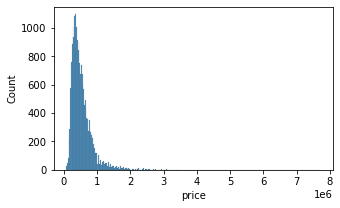

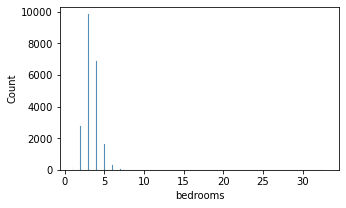

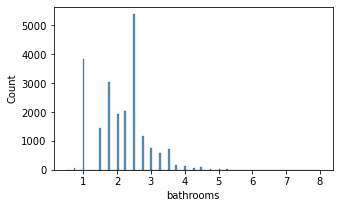

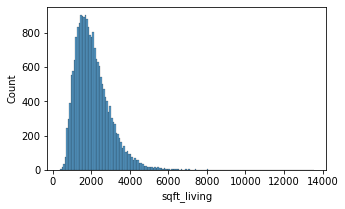

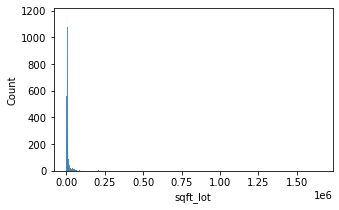

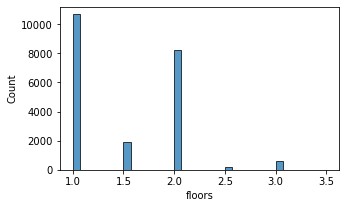

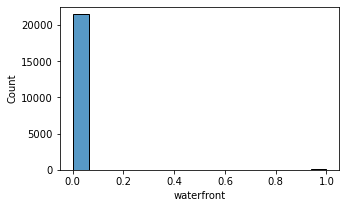

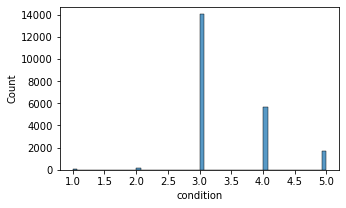

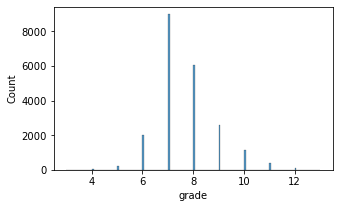

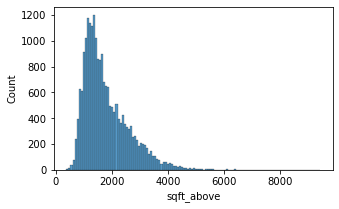

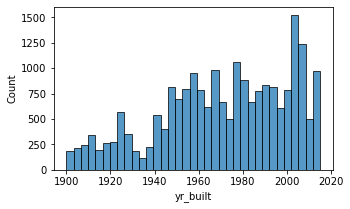

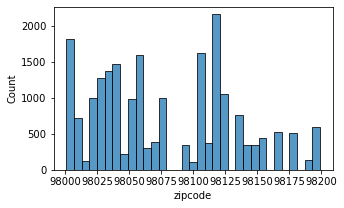

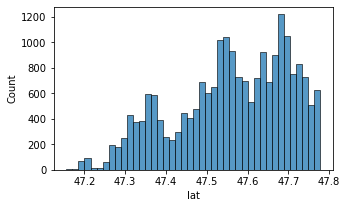

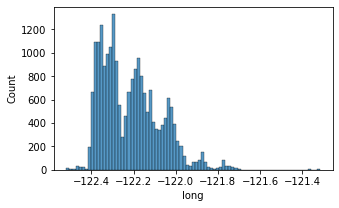

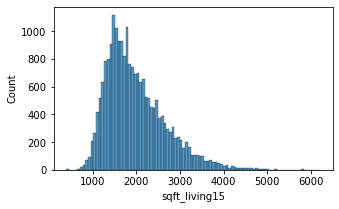

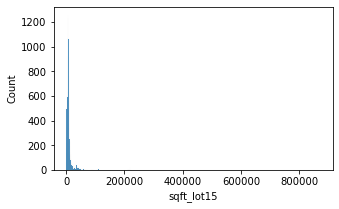

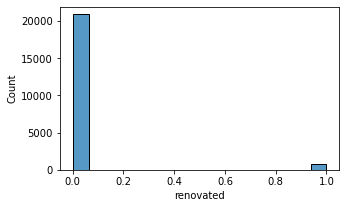

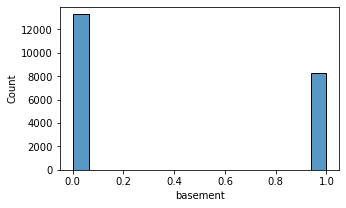

In [39]:
cols=df.columns

for c in cols:
    fig,ax=plt.subplots(figsize=(5,3))
    sns.histplot(data=df[c],ax=ax)

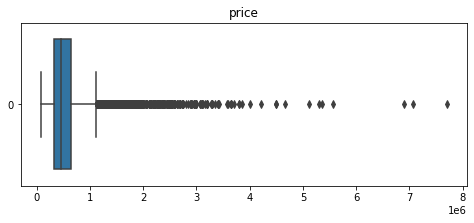

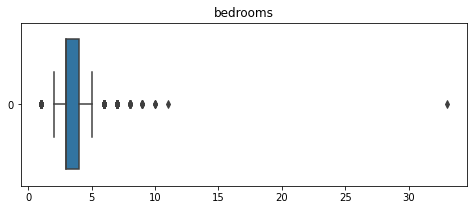

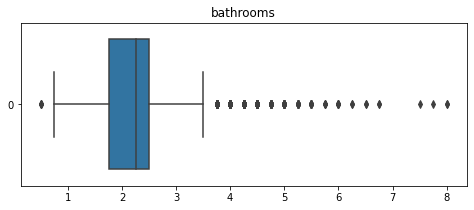

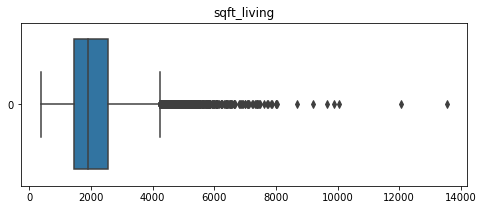

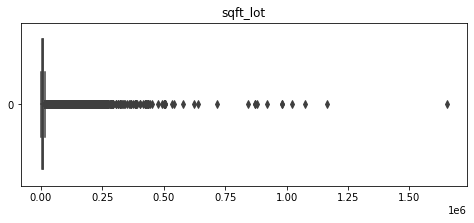

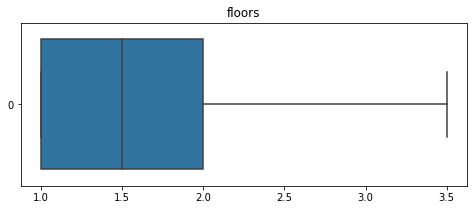

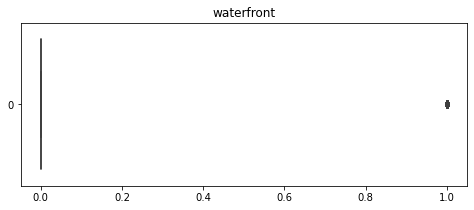

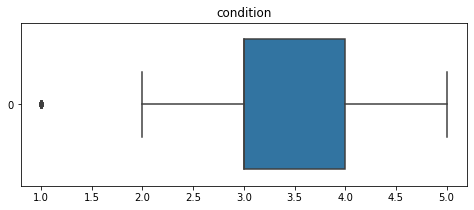

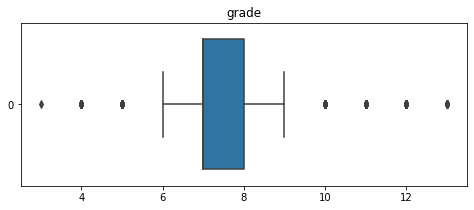

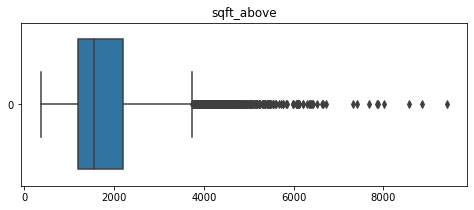

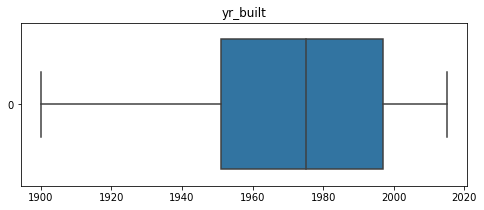

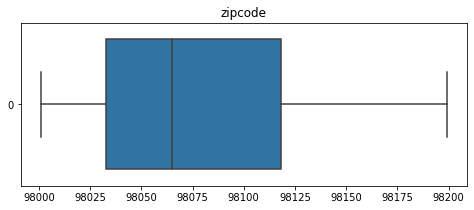

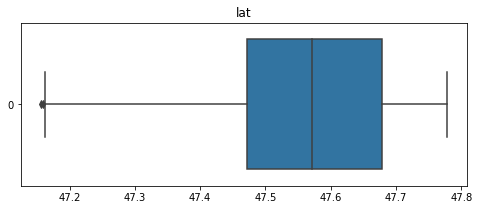

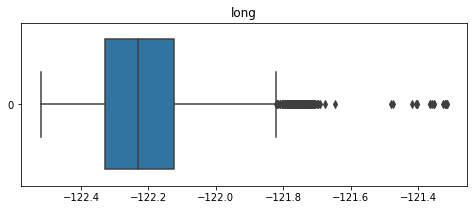

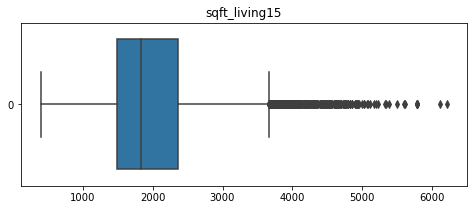

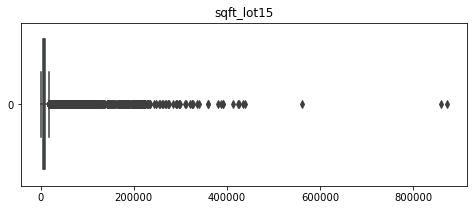

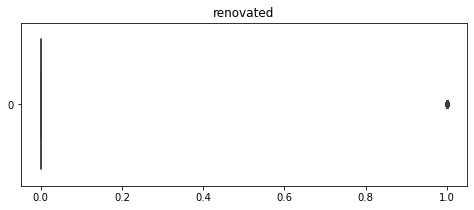

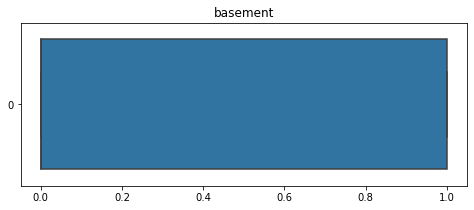

In [42]:
cols=df.columns

for c in cols:
    fig,ax=plt.subplots(figsize=(8,3))
    sns.boxplot(data=df[c],orient='h',ax=ax)
    ax.set_title(c)

There appear to be houses in the data set that would not apply to single-family home buyers.  

I'll start by including only houses with 5 or less bedrooms, removing all low outliers for condition and grade, and removing any sqft_lot above 500,000 then check to see how price, bathroom, sqft_living are affected.